In [1]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
class StockProcess:
    def __init__(self):
        self.stock = deque()
        self.total_stock = 0
        self.total_cost = 0
        self.money_cost = 0
        
    def buy(self, price, count):
        self.stock.append((price, count))
        self.total_stock += count
        self.total_cost += price * count
        self.money_cost += price * count + 20
        
    def get_divident(self, divident):
        total = divident * self.total_stock
        self.total_cost -= total
        return total
    
    def get_divident_stock(self, divident):
        total = divident * self.total_stock / 10
        self.total_stock += total
        return total
    
    def avg_cost(self):
        return self.total_cost/self.total_stock
    
    def compute_value(self, stock_price):
        return stock_price * self.total_stock
    
    def return_rate(self, stock_price):
        if self.total_stock:
            return stock_price * self.total_stock / self.money_cost - 1
        return 0

In [3]:
def get_data(target):
    stock_data_file_name = f'{target}.TW.csv'
    data_stock = pd.read_csv(stock_data_file_name)
    data_stock['Date'] = pd.to_datetime(data_stock['Date'])

    data_dividend = pd.read_csv(f'{target}_dividend.csv')
    if target == '0050':
        data_dividend.iloc[0, 2] = 0.7
    data_dividend['Date'] = pd.to_datetime(data_dividend['Date'])
    data_dividend = data_dividend[['Date', 'Cash Dividend', 'Stock Dividend']]
    data_dividend.columns = ['Date', 'Dividends', 'Stock_div']
    data_dividend = data_dividend[data_stock['Date'].min() < data_dividend['Date']]
    
    # na
    data_stock = data_stock.dropna()
    
    data = data_stock.set_index('Date').join(data_dividend.set_index('Date'), on='Date')
    return data

Some rule

In [4]:
# 定時定額
def fix_time_cash(target, start_time, end_time):
    data = get_data(target)
    litte_c = StockProcess()
    start_date = pd.to_datetime(start_time)
    end_date = pd.to_datetime(end_time)
    money = 10000
    data['return_rate'] = 0
    total_div = 0

    for day, price in data.iterrows():
        if start_date < day <= end_date:
            if not np.isnan(price['Dividends']):
                total_div = litte_c.get_divident(price['Dividends'])
            if not np.isnan(price['Stock_div']):
                litte_c.get_divident_stock(price['Stock_div'])
                
            # 固定星期三 買
            if day.dayofweek == 2:
                buy_price = (price['Open'] + price['Close'])/2
                return_rate = litte_c.return_rate(buy_price)
                buy_count = int(money/buy_price)
                litte_c.buy(buy_price, buy_count)
                
        return_rate = litte_c.return_rate(price['Close'])
        data.loc[day, 'return_rate'] = return_rate
    return data

In [5]:
# 定時固定股數
def fix_time_count(target, start_time, end_time):
    data = get_data(target)
    litte_c = StockProcess()
    start_date = pd.to_datetime(start_time)
    end_date = pd.to_datetime(end_time)
    data['return_rate'] = 0

    for day, price in data.iterrows():
        if start_date < day <= end_date:
            if not np.isnan(price['Dividends']):
                total_div = litte_c.get_divident(price['Dividends'])
            if not np.isnan(price['Stock_div']):
                litte_c.get_divident_stock(price['Stock_div'])
                
            # 固定星期三 買
            if day.dayofweek == 2:
                buy_price = (price['Open'] + price['Close'])/2
                return_rate = litte_c.return_rate(buy_price)
                buy_count = 100
                litte_c.buy(buy_price, buy_count)
                
        return_rate = litte_c.return_rate(price['Close'])
        data.loc[day, 'return_rate'] = return_rate
    return data

In [6]:
# 定時定額(股利再投入)
def fix_time_cash_add_div(target, start_time, end_time):
    data = get_data(target)
    litte_c = StockProcess()
    start_date = pd.to_datetime(start_time)
    end_date = pd.to_datetime(end_time)
    money = 10000
    data['return_rate'] = 0
    total_div = 0

    for day, price in data.iterrows():
        if start_date < day <= end_date:
            if not np.isnan(price['Dividends']):
                total_div = litte_c.get_divident(price['Dividends'])
                money += total_div
            if not np.isnan(price['Stock_div']):
                litte_c.get_divident_stock(price['Stock_div'])
                
            # 固定星期三 買
            if day.dayofweek == 2:
                buy_price = (price['Open'] + price['Close'])/2
                return_rate = litte_c.return_rate(buy_price)
                buy_count = int(money/buy_price)
                litte_c.buy(buy_price, buy_count)
                money = 10000
        return_rate = litte_c.return_rate(price['Close'])
        data.loc[day, 'return_rate'] = return_rate
    return data

In [7]:
# 定時定額 且依照報酬率決定投入金額
def fix_time_cash_by_return(target, start_time, end_time, more_para=5):
    data = get_data(target)
    litte_c = StockProcess()
    start_date = pd.to_datetime(start_time)
    end_date = pd.to_datetime(end_time)
    money = 10000
    data['return_rate'] = 0
    total_div = 0

    for day, price in data.iterrows():
        if start_date < day <= end_date:
            if not np.isnan(price['Dividends']):
                total_div = litte_c.get_divident(price['Dividends'])
            if not np.isnan(price['Stock_div']):
                litte_c.get_divident_stock(price['Stock_div'])
                
            # 固定星期三 買
            if day.dayofweek == 2:
                buy_price = (price['Open'] + price['Close'])/2
                return_rate = litte_c.return_rate(buy_price)
                buy_count = int(money/buy_price)
                if return_rate < 0:
                    buy_count *= 1 + abs(return_rate) * more_para
                litte_c.buy(buy_price, buy_count)

        return_rate = litte_c.return_rate(price['Close'])
        data.loc[day, 'return_rate'] = return_rate
    return data

In [8]:
# 定時定額 且依照報酬率決定投入金額 股利再投入
def fix_time_cash_by_return_add_div(target, start_time, end_time, more_para=5):
    data = get_data(target)
    litte_c = StockProcess()
    start_date = pd.to_datetime(start_time)
    end_date = pd.to_datetime(end_time)
    money = 10000
    data['return_rate'] = 0
    total_div = 0

    for day, price in data.iterrows():
        if start_date < day <= end_date:
            if not np.isnan(price['Dividends']):
                total_div = litte_c.get_divident(price['Dividends'])
                money += total_div
            if not np.isnan(price['Stock_div']):
                litte_c.get_divident_stock(price['Stock_div'])
                
            # 固定星期三 買
            if day.dayofweek == 2:
                buy_price = (price['Open'] + price['Close'])/2
                return_rate = litte_c.return_rate(buy_price)
                buy_count = int(money/buy_price)
                if return_rate < 0:
                    buy_count *= 1 + abs(return_rate) * more_para
                litte_c.buy(buy_price, buy_count)
                money = 10000
        return_rate = litte_c.return_rate(price['Close'])
        data.loc[day, 'return_rate'] = return_rate
    return data

In [13]:
target = '2812'
start, end = '2000-01-01', '2020-10-25'
tmp_df = pd.DataFrame()

data = fix_time_count(target, start, end)
tmp_df['fix_time_count'] = data['return_rate']
tmp_df.index = data.index

data = fix_time_cash(target, start, end)
tmp_df['fix_time_cash'] = data['return_rate']

data = fix_time_cash_add_div(target, start, end)
tmp_df['fix_time_cash_add_div'] = data['return_rate']

data = fix_time_cash_by_return(target, start, end)
tmp_df['fix_time_cash_by_return'] = data['return_rate']

data = fix_time_cash_by_return_add_div(target, start, end)
tmp_df['fix_time_cash_by_return_add_div'] = data['return_rate']

tmp_df

,fix_time_count,fix_time_cash,fix_time_cash_add_div,fix_time_cash_by_return,fix_time_cash_by_return_add_div
Date,,,,,
2002-02-19,0.000000,0.000000,0.000000,0.000000,0.000000
2002-02-20,-0.041630,-0.003167,-0.003167,-0.003167,-0.003167
2002-02-21,-0.043880,-0.005507,-0.005507,-0.005507,-0.005507
2002-02-22,-0.064127,-0.026566,-0.026566,-0.026566,-0.026566
2002-02-25,-0.095622,-0.059325,-0.059325,-0.059325,-0.059325
...,...,...,...,...,...
2020-10-23,0.820179,1.013592,0.834145,1.181940,0.947467
2020-10-26,0.845459,1.041558,0.859619,1.212244,0.974515
2020-10-27,0.837032,1.032236,0.851128,1.202143,0.965499


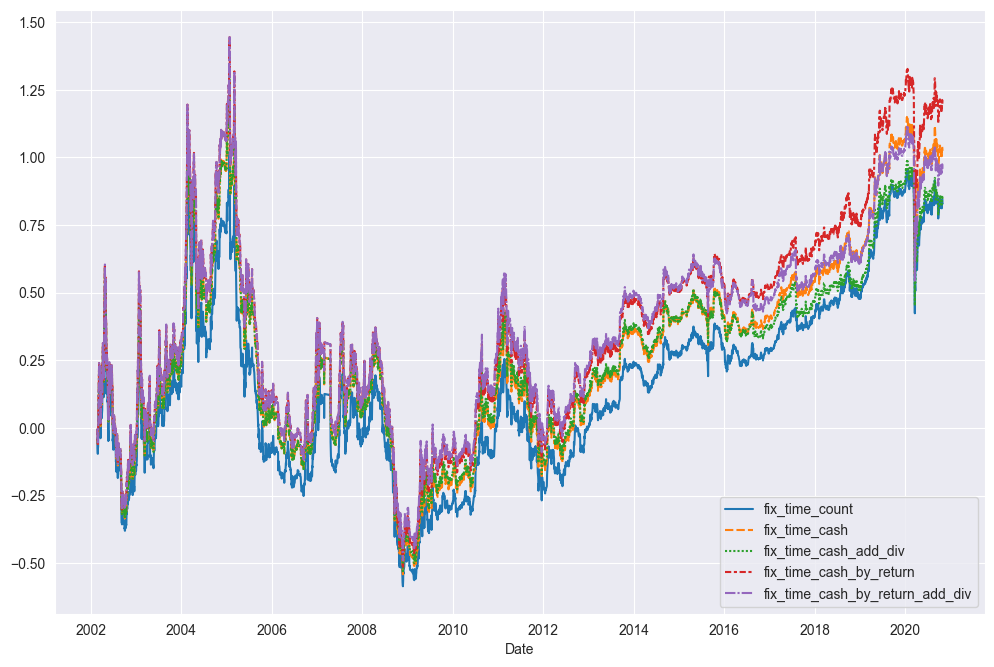

In [14]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 
sns.lineplot(data=tmp_df[tmp_df.sum(axis=1) != 0])
plt.show()